# Problema: Masa Resorte Amortiguador

In [ ]:
# Librerias utiles
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import imageio.v2 as imageio
from google.colab import drive
from google.colab import files
from os import TMP_MAX

# Modelo Físico

In [ ]:
# Parámetros físicos
l0 = 0.25 # m
g = 9.81  # m/s^2
m = 1     # kg
b = 0.5     # Ns/m
k = 2    # N/m
tiempo_total = 20 # s
delta_T = 0.01 # s
t_datos = 0.5*tiempo_total

In [ ]:
# Calculo de parámetros útiles
omega = np.sqrt(k/m)
seda  = b/(2*np.sqrt(m*k))
phi = np.arctan(-seda)
# Definir el vector de tiempo
t = np.arange(0, tiempo_total, delta_T)

print(f"omega = {omega}")
print(f"seda = {seda}")
print(f"phi = {phi}")


omega = 1.4142135623730951
seda = 0.17677669529663687
phi = -0.17496904566568885


In [ ]:
# Calcular desplazamiento y posición
def desplazamiento(tiempo):
  despl = (g / omega**2) * (1 - np.exp(-seda * omega * tiempo)* np.cos(omega * tiempo + phi)/np.cos(phi))
  return despl

u = desplazamiento(t)
x = u + l0


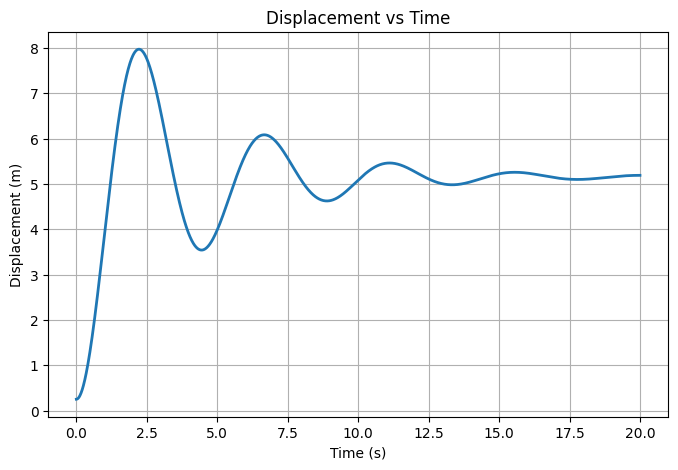

In [ ]:
# Graficar
plt.figure(figsize=(8, 5))
plt.plot(t, x, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.grid(True)
plt.title('Displacement vs Time')
plt.show()

# Parámetros para Modelos Predictivos

In [ ]:
# Crear datos de entrada para la red neuronal
# X es un vector de n valores seleccionados entre 0 y 10
n = 25 # Numero de muestras
t_max = t_datos # Tiempo maximo
t_min = 0 # Tiempo minimo
X = np.arange(t_min, t_max, (t_max-t_min)/n)
y = desplazamiento(X)
X_collocation = np.arange(0.0, tiempo_total, tiempo_total/100)
X_i = np.array([[0.0]])
b_init = np.array([[0.0]])

In [ ]:
# Convertir a tensores de PyTorch
X_train = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
X_test  = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
y_test  = torch.tensor(u, dtype=torch.float32).reshape(-1, 1)
X_train_phy = torch.tensor(X_collocation, dtype=torch.float32).reshape(-1, 1)
X_init = torch.tensor(X_i, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Parametros de la Red Neuronal
epochs_FFNN = 10000
epochs_PINN = 50000
epochs_PINN_id = 100000
epochs_PINN_adm_id = 500000
learning_rate = 2e-4
nneurons = 64
nhiden_layers = 4
activation_fn = nn.Tanh()
make_video = False

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

# Modelo adimensionalizado

## Adimensionalizando... 📏

In [ ]:
# Variables de adimensionalizacion
U_ref = m*g/k
T_ref = 1/omega

# Admiensionalizacion
X_train_adm = X_train/T_ref
y_train_adm = y_train/U_ref
X_test_adm  = X_test/T_ref
y_test_adm  = y_test/U_ref
X_train_phy_adm = X_train_phy/T_ref
X_init_adm = X_init/T_ref
#Y_init = torch.tensor([0.0, 0.0, 0.0])
#y_init_adm = torch.tensor([0.0])/U_ref
#dy_init_adm = torch.tensor([0.0])*T_ref/U_ref
#ddy_init_adm = torch.tensor([g*(1-seda**2)])*T_ref**2/U_ref
#Y_init_adm = torch.cat((y_init_adm, dy_init_adm, ddy_init_adm), dim=0)


t_min = X_test_adm.min()
t_max = X_test_adm.max()
Delta_t_adm = (t_max - t_min)
Delta_t_adm.retain_grad = False
u_min = y_test_adm.min()
u_min.retain_grad = False
u_max = y_test_adm.max()
Delta_u_adm = (u_max - u_min)
Delta_u_adm.retain_grad = False

# Modelo Predictivo ADIMENSIONALIZADO - FFNN

## Clase Deep Neural Network 🧠

In [ ]:
class DNN(nn.Module):

  # Inicialización de la RED
  def __init__(self, layers):
    super(DNN, self).__init__() # Llama __init__ de la clase padre

    # Funcion de activacion
    self.activation_fn = activation_fn

    # Historial de loss
    self.loss_history = []

    # Definir capas (crea una lista de capas Fully connected)
    self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    # Inicializacion de pesos Xavier Glorot y bias como ceros
    for i in range(len(layers)-1):
      # Pesos
      nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
      # Bias
      nn.init.zeros_(self.layers[i].bias.data)

  # Propagación hacia adelante
  def forward(self, x):
    for i in range(len(layers)-2):
      x = self.activation_fn(self.layers[i](x))

    x = self.layers[-1](x)
    return x

## Instanciar el modelo ⛏

In [ ]:
# Instanciar modelo, definir función de pérdida y optimizador
model_ffnn_adm = DNN(layers)
loss_fn = nn.MSELoss(reduction = "mean")
optimizer = optim.Adam(model_ffnn_adm.parameters(), lr=learning_rate)

## Entrenar 🦾

In [ ]:
# Entrenar el modelo

frames = [] # Lista para guardar imágenes

for epoch in range(epochs_FFNN):
  # Forward
  y_pred_adm = model_ffnn_adm(X_train_adm)
  loss = loss_fn(y_pred_adm, y_train_adm)
  model_ffnn_adm.loss_history.append(loss.item())

  # Backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch) % 10 == 0:
    print(f'Epoch [{epoch}/{epochs_FFNN}], Loss: {loss.item():.6f}')

    if make_video:
      # Haciendo plots para video
      y_pred_adm = model_ffnn_adm(X_test_adm).detach().numpy()
      plt.figure(figsize=(8, 5))
      plt.plot(X_test, y_test_adm, label='Real', linewidth=1.5)
      plt.plot(X_test, y_pred_adm, label='Predicho', linewidth=1.5, linestyle='dashed')
      # plot los puntos de evaluacion con X
      plt.scatter(X_train[:, 0], y_train, color='red', label='Puntos de evaluación', marker= 'x')
      plt.xlabel('Time (seda)')
      plt.ylabel('Displacement (m)')
      plt.legend()
      plt.title(f"Epoch {epoch}")
      plt.savefig(f"frame_{epoch}.png")
      plt.close()
      frames.append(imageio.imread(f"frame_{epoch}.png"))

if make_video:
  # Guardar el GIF
  gif_path = "/content/training_animation.gif"
  imageio.mimsave(gif_path, frames, duration=0.5)
  files.download(gif_path)

Epoch [0/10000], Loss: 1.219524
Epoch [10/10000], Loss: 0.176316
Epoch [20/10000], Loss: 0.162450
Epoch [30/10000], Loss: 0.107258
Epoch [40/10000], Loss: 0.081031
Epoch [50/10000], Loss: 0.071196
Epoch [60/10000], Loss: 0.061340
Epoch [70/10000], Loss: 0.056956
Epoch [80/10000], Loss: 0.054426
Epoch [90/10000], Loss: 0.052725
Epoch [100/10000], Loss: 0.051569
Epoch [110/10000], Loss: 0.050676
Epoch [120/10000], Loss: 0.049899
Epoch [130/10000], Loss: 0.049189
Epoch [140/10000], Loss: 0.048535
Epoch [150/10000], Loss: 0.047932
Epoch [160/10000], Loss: 0.047376
Epoch [170/10000], Loss: 0.046862
Epoch [180/10000], Loss: 0.046385
Epoch [190/10000], Loss: 0.045942
Epoch [200/10000], Loss: 0.045527
Epoch [210/10000], Loss: 0.045138
Epoch [220/10000], Loss: 0.044770
Epoch [230/10000], Loss: 0.044422
Epoch [240/10000], Loss: 0.044091
Epoch [250/10000], Loss: 0.043775
Epoch [260/10000], Loss: 0.043472
Epoch [270/10000], Loss: 0.043180
Epoch [280/10000], Loss: 0.042898
Epoch [290/10000], Loss: 

## Evaluar resultados 📈

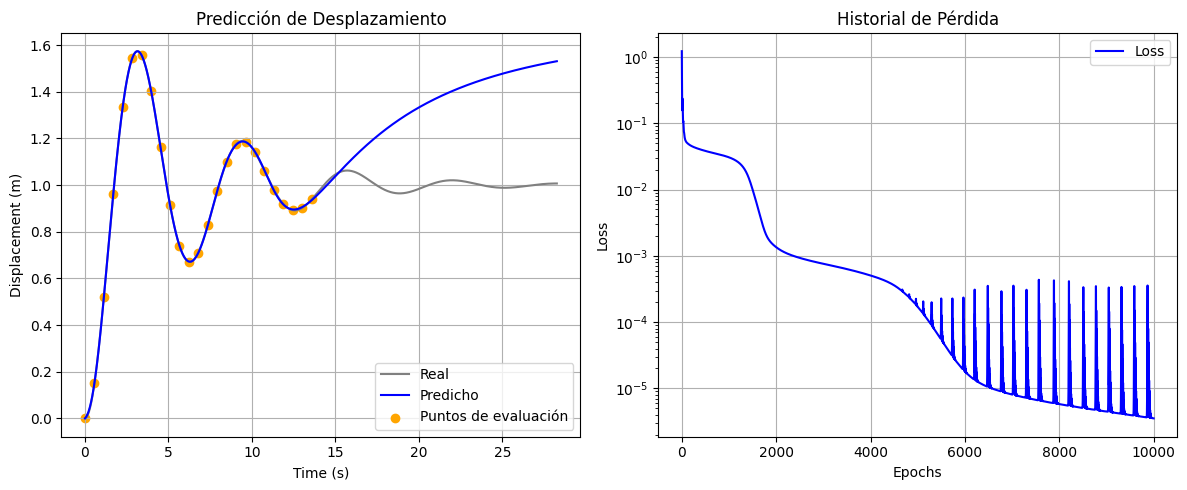

In [ ]:
# Hacer predicciones
model_ffnn_adm.eval()
y_pred_adm = model_ffnn_adm(X_test_adm).detach().numpy()

# Crear una figura con 2 subgráficos (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Gráfico 1: Predicción vs Real ---
axs[0].plot(X_test_adm, y_test_adm, label='Real', linewidth=1.5, color = 'grey')
axs[0].plot(X_test_adm, y_pred_adm, label='Predicho', linewidth=1.5, color = 'blue')
axs[0].scatter(X_train_adm[:, 0], y_train_adm, color='orange', label='Puntos de evaluación', marker='o')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Displacement (m)')
axs[0].grid(True)
axs[0].set_title('Predicción de Desplazamiento')
axs[0].legend()

# --- Gráfico 2: Historial de pérdida ---
axs[1].semilogy(model_ffnn_adm.loss_history, label='Loss', color='blue', linewidth=1.5)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].set_title('Historial de Pérdida')
axs[1].legend()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

# Modelo de Identificación ADIMENSIONALIZADO - PINN_id_𝒜

## Clase PINN_adm ⚛

In [ ]:
class PINN_adm():
  def __init__(self,layers):

    # funcion de perdida
    self.loss_fn = nn.MSELoss(reduction = "mean")

    # Inicializando iterador
    self.iter = 0

    # Inicializando la DNN
    self.dnn = DNN(layers)
    self.b = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    self.b = nn.Parameter(self.b)
    self.dnn.register_parameter('b', self.b)
    self.parameter_history = {"b":[]}

    # Inicializando el historial de losses
    self.loss_history = {"Data":[],
                         "Physics":[],
                         "IC":[],
                         "Total":[],
                        }
  def loss_data(self, X, y):
    y_pred = self.dnn(X).reshape(-1,1)
    loss_data = self.loss_fn(y_pred, y)
    self.loss_history["Data"].append(loss_data.item())
    return loss_data

  def loss_physics(self, X_phy, X_init):
    # Cálculo en el dominio de la física
    X_physics = X_phy.clone().requires_grad_(True)
    y_pred = self.dnn(X_physics).reshape(-1, 1)
    u_adm = y_pred
    b_pred = self.b
    self.parameter_history["b"].append(b_pred.item())
    seda_pred = b_pred/(2*np.sqrt(m*k))

    # Primer orden: dû*/dt^*
    du_dt_adm = torch.autograd.grad(u_adm, X_physics,
                                            torch.ones_like(u_adm),
                                            retain_graph=True, create_graph=True)[0]
    # Segundo orden: ddû*/dt^2*
    ddu_ddt_adm = torch.autograd.grad(du_dt_adm, X_physics,
                                            torch.ones_like(du_dt_adm),
                                            retain_graph=True, create_graph=True)[0]

    #loss_term_1 = 2 * Delta_u_adm * ddu_ddt_adm_norm / (Delta_t_adm ** 2)
    #loss_term_2 = 2 * seda * Delta_u_adm * du_dt_adm_norm / Delta_t_adm
    #loss_term_3 = (u_adm_norm + 1) * Delta_u_adm / 2 + u_min
    #loss_term_4 = g / (omega ** 2 * U_ref)

    loss_physics = torch.norm(ddu_ddt_adm + 2*seda_pred*du_dt_adm + u_adm - g/(U_ref*omega**2))
    self.loss_history["Physics"].append(loss_physics.item())

    # En el instante inicial:
    # u(0) = 0
    # du/dt(0) = 0
    # ddu/ddt(0) = g(1-seda**2)
    X_initial = X_init.clone().requires_grad_(True)
    y_pred_init = self.dnn(X_initial).reshape(-1,1)
    u_init_adm = y_pred_init
    du_dt_init_adm = torch.autograd.grad(u_init_adm, X_initial,
                                              torch.ones_like(u_init_adm),
                                              retain_graph=True, create_graph=True)[0]
    ddu_ddt_init_adm = torch.autograd.grad(du_dt_init_adm, X_initial,
                                                torch.ones_like(du_dt_init_adm),
                                                retain_graph=True, create_graph=True)[0]

    aceleracion_norm = torch.tensor([g*(1-seda_pred**2)])*T_ref**2/U_ref
    loss_IC_term_1 = torch.norm(u_init_adm)
    loss_IC_term_2 = torch.norm(du_dt_init_adm)
    loss_IC_term_3 = torch.norm(ddu_ddt_init_adm - aceleracion_norm)

    loss_IC = loss_IC_term_1 + loss_IC_term_2 + loss_IC_term_3
    self.loss_history["IC"].append(loss_IC.item())

    return loss_physics, loss_IC


  def loss_total(self, X, y, X_phy, X_init):
    loss_data = self.loss_data(X, y)
    loss_physics, loss_IC = self.loss_physics(X_phy, X_init)
    loss_total = loss_data + loss_physics + loss_IC
    self.loss_history["Total"].append(loss_total.item())
    return loss_total, loss_data, loss_physics, loss_IC

## Instanciar el modelo ⛏

In [ ]:
# Instanciar modelo, definir función de pérdida y optimizador
model_pinn_adm = PINN_adm(layers)
loss_fn = nn.MSELoss(reduction = "mean")
optimizer = optim.Adam(model_pinn_adm.dnn.parameters(), lr=learning_rate)

## Entrenar 🦾

In [ ]:
for epoch in range(epochs_PINN_adm_id):
  # Forward
  loss, loss_data, loss_physics, loss_IC = model_pinn_adm.loss_total(X_train_adm,
                                                                          y_train_adm,
                                                                          X_train_phy_adm,
                                                                          X_init_adm)

  # Backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch) % 100 == 0:
    print(f'Epoch [{epoch}/{epochs_PINN_adm_id}], Loss_T: {loss.item():.6f}, Loss_data: {loss_data.item():.6f}, Loss_physics: {loss_physics.item():.6f}, Loss_IC: {loss_IC.item():.6f}, b_pred (real): {model_pinn_adm.b.item():.3f}({b})')

    if make_video:
      # Haciendo plots para video
      y_pred_adm = model_pinn_adm(X_test).detach().numpy()
      plt.figure(figsize=(8, 5))
      plt.plot(X_test_adm, y_test_adm, label='Real', linewidth=1.5)
      plt.plot(X_test_adm, y_pred_adm, label='Predicho', linewidth=1.5, linestyle='dashed')
      # plot los puntos de evaluacion con X
      plt.scatter(X_train_adm, y_train_adm, color='red', label='Puntos de evaluación', marker= 'x')
      plt.xlabel('Time (seda)')
      plt.ylabel('Displacement (m)')
      plt.legend()
      plt.title(f"Epoch {epoch}")
      plt.savefig(f"frame_{epoch}.png")
      plt.close()
      frames.append(imageio.imread(f"frame_{epoch}.png"))

if make_video:
  # Guardar el GIF
  gif_path = "/content/training_animation.gif"
  imageio.mimsave(gif_path, frames, duration=0.5)
  files.download(gif_path)

Epoch [0/500000], Loss_T: 13.288888, Loss_data: 1.072960, Loss_physics: 11.152896, Loss_IC: 1.063032, b_pred (real): -0.000(0.5)
Epoch [100/500000], Loss_T: 3.329375, Loss_data: 0.074696, Loss_physics: 1.588811, Loss_IC: 1.665868, b_pred (real): 0.020(0.5)
Epoch [200/500000], Loss_T: 2.597937, Loss_data: 0.100515, Loss_physics: 0.528727, Loss_IC: 1.968695, b_pred (real): 0.036(0.5)
Epoch [300/500000], Loss_T: 2.360669, Loss_data: 0.129482, Loss_physics: 0.196084, Loss_IC: 2.035104, b_pred (real): 0.038(0.5)
Epoch [400/500000], Loss_T: 2.349713, Loss_data: 0.128752, Loss_physics: 0.215288, Loss_IC: 2.005673, b_pred (real): 0.039(0.5)
Epoch [500/500000], Loss_T: 2.200942, Loss_data: 0.128935, Loss_physics: 0.061795, Loss_IC: 2.010211, b_pred (real): 0.039(0.5)
Epoch [600/500000], Loss_T: 2.179680, Loss_data: 0.128815, Loss_physics: 0.047992, Loss_IC: 2.002872, b_pred (real): 0.039(0.5)
Epoch [700/500000], Loss_T: 2.164386, Loss_data: 0.127285, Loss_physics: 0.051600, Loss_IC: 1.985500, b

## Evaluar resultados 📈


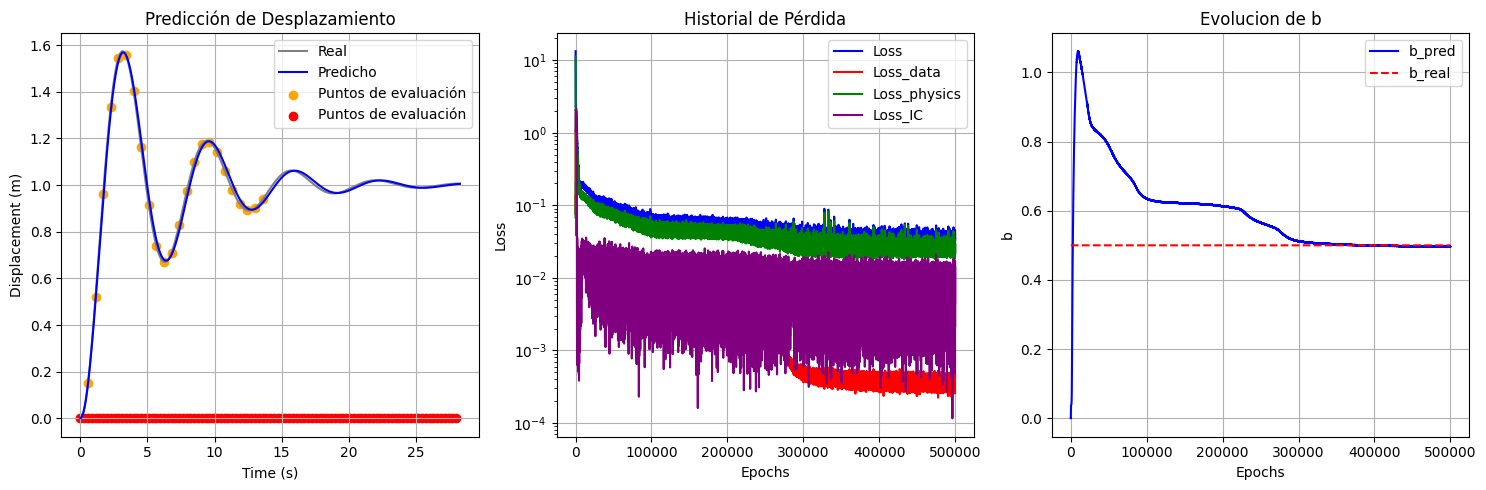

In [ ]:
# Hacer predicciones
y_pred_adm = model_pinn_adm.dnn(X_test_adm).detach().numpy()

# Crear una figura con 2 subgráficos (1 fila, 3 columnas)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# --- Gráfico 1: Predicción vs Real ---
axs[0].plot(X_test_adm[:, 0].numpy(), y_test_adm.numpy(), label='Real', linewidth=1.5, color = 'grey')
axs[0].plot(X_test_adm[:, 0].numpy(), y_pred_adm, label='Predicho', linewidth=1.5, color = 'blue')
axs[0].scatter(X_train_adm[:, 0], y_train_adm, color='orange', label='Puntos de evaluación', marker='o')
axs[0].scatter(X_train_phy_adm.detach().numpy(), np.zeros_like(X_collocation), color='red', label='Puntos de evaluación', marker= 'o')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Displacement (m)')
axs[0].grid(True)
axs[0].set_title('Predicción de Desplazamiento')
axs[0].legend()

# --- Gráfico 2: Historial de pérdida ---
axs[1].semilogy(model_pinn_adm.loss_history["Total"], label='Loss', color='blue', linewidth=1.5)
axs[1].semilogy(model_pinn_adm.loss_history["Data"], label='Loss_data', color='red', linewidth=1.5)
axs[1].semilogy(model_pinn_adm.loss_history["Physics"], label='Loss_physics', color='green', linewidth=1.5)
axs[1].semilogy(model_pinn_adm.loss_history["IC"], label='Loss_IC', color='purple', linewidth=1.5)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].set_title('Historial de Pérdida')
axs[1].legend()

# --- Grafico 3: Evolucion de b
axs[2].plot(model_pinn_adm.parameter_history["b"], label='b_pred', color='blue', linewidth=1.5)
# Grafica de b real
axs[2].plot(np.ones_like(model_pinn_adm.parameter_history["b"])*b, label='b_real', color='red', linewidth=1.5, linestyle = "dashed")
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('b')
axs[2].grid(True)
axs[2].set_title('Evolucion de b')
axs[2].legend()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()